## Analysing German Dataset and training RF

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score

### Get + Prepare Data

In [2]:
# Read German dataset using fetch_ucirepo lib
statlog_german_credit_data = fetch_ucirepo(id=144)
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
df_original = pd.concat([X,y], axis=1)

# Prepare data
target_column_name = 'class'
X = df_original.drop(columns=[target_column_name])
y = df_original[target_column_name]
y = y.map({2:0, 1: 1}) # 2 for bad and 1 for good --> 0 for bad and 1 for good
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample class 0 (bad)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Let class 0 (bad) be with '5' weight, since class is undersampled
# class_weights = {0:5, 1:1}
class_weights = 'balanced'

### Grid Search: choosing best params

In [3]:
# Search for best params
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='f1_macro', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [4]:
TOP_N = 10
top_params = results_df.head(TOP_N)
top_params[[c for c in top_params.columns if c.startswith('param_')] + ['mean_test_score','std_test_score']].reset_index()

,index,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,8,20,log2,2,2,50,0.795283,0.113967
1,11,20,log2,2,5,100,0.790967,0.119902
2,9,20,log2,2,2,100,0.788552,0.115506
3,5,20,sqrt,4,2,100,0.787121,0.108489
4,7,20,sqrt,4,5,100,0.787121,0.108489
5,3,20,sqrt,2,5,100,0.786957,0.120201
6,10,20,log2,2,5,50,0.784773,0.122094
7,13,20,log2,4,2,100,0.782002,0.120405
8,15,20,log2,4,5,100,0.782002,0.120405
9,12,20,log2,4,2,50,0.780064,0.133295


In [5]:
"""CHOOSE PARAMS FOR RF"""
# params = {} # Default
params = top_params['params'].iloc[0]

### Testing different NUM_FEATURES and THRESHOLD values

In [60]:
thresholds = np.arange(0.5, 0.66, 0.05)
num_features = np.arange(13, 14 + 1, 1)

accuracy_results = np.zeros((len(thresholds), len(num_features)))
f1_class0_results = np.zeros((len(thresholds), len(num_features)))
f1_class1_results = np.zeros((len(thresholds), len(num_features)))

for i, threshold in enumerate(tqdm(thresholds)):
    for j, n_features in enumerate(num_features):
        # Select top N features
        top_features = importance_df.head(n_features)
        X_train_reduced = X_train[top_features['Feature']]
        X_test_reduced = X_test[top_features['Feature']]

        # Train the model with reduced features
        rf_reduced = RandomForestClassifier(class_weight=class_weights, random_state=42, n_jobs=-1)
        rf_reduced.fit(X_train_reduced, y_train)
        
        # Predict with the given threshold
        y_pred_prob = rf_reduced.predict_proba(X_test_reduced)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Compute metrics
        accuracy_results[i, j] = accuracy_score(y_test, y_pred)
        f1_class0_results[i, j] = f1_score(y_test, y_pred, pos_label=0)
        f1_class1_results[i, j] = f1_score(y_test, y_pred, pos_label=1)

%matplotlib widget
# Plot the 3D graph for accuracy and F1 scores
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

T, F = np.meshgrid(thresholds, num_features, indexing='ij')

ax.plot_surface(T, F, accuracy_results, cmap="Blues", alpha=0.6)
ax.plot_surface(T, F, f1_class0_results, cmap="Reds", alpha=0.6)
ax.plot_surface(T, F, f1_class1_results, cmap="Greens", alpha=0.6)

ax.set_xlabel('Threshold')
ax.set_ylabel('Number of Features')
ax.set_zlabel('Metric Value')
ax.set_title('Performance Metrics vs Threshold and Number of Features')

plt.show()

100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


### Running RF with chosen params

In [6]:
rf = RandomForestClassifier(**params, class_weight=class_weights, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

N_FEATURES = 5
THRESHOLD = 0.58

top_features = importance_df.head(N_FEATURES)

X_train_reduced = X_train[top_features['Feature']]
X_test_reduced = X_test[top_features['Feature']]

# Train the model again with reduced features
rf_reduced = RandomForestClassifier(**params, class_weight=class_weights, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)
# Predict
if THRESHOLD:
    y_pred_prob = rf_reduced.predict_proba(X_test_reduced)[:, 1]
    y_pred = (y_pred_prob >= THRESHOLD).astype(int)
else:
    y_pred = rf_reduced.predict(X_test_reduced)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.68      0.60        59
           1       0.85      0.75      0.80       141

    accuracy                           0.73       200
   macro avg       0.69      0.71      0.70       200
weighted avg       0.76      0.73      0.74       200



### Transforming data to Human-readable format

In [7]:
base_features = list(set(feature.split('_')[0] for feature in top_features['Feature']))

to_remove = [
    'Attribute4'
]

base_features = [f for f in base_features if f not in to_remove]

In [8]:
feature_transformations = {
    "Attribute1": {
        "new_name": "Bank account status",
        "value_mapping": {
            "A14": "No account in bank",
            "A11": "Bank account value < 0 $",
            "A12": "Bank account value < 2000 $",
            "A13": "Bank account value > 2000 $",
        },
    },
    "Attribute6": {
        "new_name": "Savings account status",
        "value_mapping": {
            "A65": "No savings account in bank",
            "A61": "Savings < 1000 $",
            "A62": "Savings 1000-5000 $",
            "A63": "Savings > 5000 $",
            "A64": "Savings > 5000 $",
        },
    },
    "Attribute3": {
        "new_name": "Credit history",
        "value_mapping": {
            "A30": "No credits taken",
            "A31": "All credits paid duly at this bank",
            "A32": "Existing credits paid duly till now",
            "A33": "Delay in paying off in the past",
            "A34": "Established but risky credit history",
        },
    },
    "Attribute15": {
        "new_name": "Housing status",
        "value_mapping": {
            "A151": "Rented",
            "A152": "Owned",
            "A153": "Living with parents",
        },
    },
    "Attribute9": {
        "new_name": "Personal status and sex",
        "value_mapping": {
            "A91": "Male: divorced/separated/married",
            "A92": "Female: divorced/separated/married",
            "A93": "Male: single",
            "A94": "Male: divorced/separated/married",
            "A95": "Female: single",
        },
    },
    "Attribute14": {
        "new_name": "Other credits",
        "value_mapping": {
            "A141": "Has other credits",
            "A142": "Has other credits",
            "A143": "Has no other credits",
        },
    },
    "Attribute5": {"new_name": "Credit amount (applicant has requested)"},
    "Attribute13": {"new_name": "Age (in years)"},
    "Attribute8": {"new_name": "Installment rate: % of income used for loan payments"},
    "Attribute2": {"new_name": "Loan duration (months)"},
}


df_cut = df_original[base_features].copy()
for c in df_cut.columns:
    mapping = feature_transformations[c]
    if 'value_mapping' in mapping:
        df_cut[mapping['new_name']] = df_cut[c].map(mapping['value_mapping'])
    else:
        # Specific transformation for Credit amount (rounding and scaling)
        if mapping['new_name'] == "Credit amount (applicant has requested)":
            df_cut[mapping['new_name']] = (df_cut[c].round(-1) * 10).astype(int)
        else:
            df_cut[mapping['new_name']] = df_cut[c]
    
df_cut.drop(base_features, axis=1, inplace=True)
df_cut['class'] = df_original['class'].map({2:0, 1: 1})

In [10]:
df_cut.columns

Index(['Age (in years)', 'Credit history', 'Bank account status',
       'Loan duration (months)', 'Credit amount (applicant has requested)',
       'class'],
      dtype='object')

In [217]:
df_cut['Bank account status'].value_counts()

Bank account status
No account in bank             394
Bank account value < 0 $       274
Bank account value < 2000 $    269
Bank account value > 2000 $     63
Name: count, dtype: int64

### Retraining RF with needed columns only

In [ ]:
"""Train tree on this data"""

target_column_name = 'class'
X_cut = df_cut.drop(columns=[target_column_name])
y_cut = df_cut[target_column_name]

X_cut = pd.get_dummies(X_cut, drop_first=False)
X_cut_train, X_cut_test, y_cut_train, y_cut_test = train_test_split(X_cut, y_cut, test_size=0.2, random_state=42)

# Oversample class 0 (bad)
smote = SMOTE(random_state=42)
X_cut_train, y_cut_train = smote.fit_resample(X_cut_train, y_cut_train)

params_cut = params
rf_cut = RandomForestClassifier(**params_cut, class_weight='balanced', random_state=42)
rf_cut.fit(X_cut_train, y_cut_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [ ]:
# # Load saved model
# import pickle
# with open('data/models/RandomForestClassifier_for_german.pkl', 'rb') as file:
#     german_model = pickle.load(file)
#     threshold = german_model['threshold']
#     rf_cut = german_model['model']

In [10]:
THRESHOLD = 0.5

# Reorder the columns of X_cut_test to match rf_cut.feature_names_in_
X_cut_test = X_cut_test.reindex(columns=rf_cut.feature_names_in_)

if THRESHOLD:
    y_pred_prob = rf_cut.predict_proba(X_cut_test)[:, 1]
    y_pred = (y_pred_prob >= THRESHOLD).astype(int)
else:
    y_pred = rf_cut.predict(X_cut_test)

print(classification_report(y_cut_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.53      0.58        59
           1       0.82      0.88      0.85       141

    accuracy                           0.78       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



In [ ]:
# import pickle
# model_to_save = {'model': rf_cut,
#                  'params': params,
#                  'classification_report': classification_report(y_cut_test, y_pred),
#                  'threshold': 0.65,
#                  'base_features': base_features,
#                  'feature_transformations': feature_transformations}

# with open("data/models/RandomForestClassifier_for_german.pkl", "wb") as file:
#     pickle.dump(model_to_save, file)

### Getting good samples

In [145]:
"""Get NUM_SAMPLES_PER_CLASS number of samples per class that wereclassified correctly with proba > CONFIDENCE_THRESHOLD"""
CONFIDENCE_THRESHOLD_1 = 0.95
CONFIDENCE_THRESHOLD_0 = 0.8
NUM_SAMPLES_PER_CLASS = 5

# Reorder the columns of X_cut to match rf_cut.feature_names_in_
X_cut = X_cut.reindex(columns=rf_cut.feature_names_in_)

y_pred_prob = rf_cut.predict_proba(X_cut)
y_pred = (y_pred_prob[:, 1] >= THRESHOLD).astype(int)

best_samples = {c:[] for c in np.unique(y_cut)}

# Find indices where RF is confident and correct
correct_indices = np.where(y_pred == y_cut)[0]
for i in correct_indices:
    real_class = y_cut.iloc[i]
    proba = y_pred_prob[i][real_class]
    if real_class == 1:
        conf_thresh = CONFIDENCE_THRESHOLD_1
    else:
        conf_thresh = CONFIDENCE_THRESHOLD_0
    if proba > conf_thresh:
        best_samples[real_class].append(i)

class_0_samples = best_samples[0][:NUM_SAMPLES_PER_CLASS]
class_1_samples = best_samples[1][:NUM_SAMPLES_PER_CLASS]

print("Number of confident samples:")
len(best_samples[0]), len(best_samples[1])

Number of confident samples:


(74, 93)

In [ ]:
import random

In [161]:
NUM_SAMPLES_MAIN_TEST = 20
class_0_samples_main_test = best_samples[0][NUM_SAMPLES_PER_CLASS:NUM_SAMPLES_PER_CLASS+NUM_SAMPLES_MAIN_TEST]
class_1_samples_main_test = best_samples[1][NUM_SAMPLES_PER_CLASS:NUM_SAMPLES_PER_CLASS+NUM_SAMPLES_MAIN_TEST]

picked_examples = class_0_samples_main_test + class_1_samples_main_test
random.shuffle(picked_examples)
df_cut.iloc[picked_examples].to_csv('data/german/picked_samples_main.csv')

In [ ]:
picked_examples = class_0_samples + class_1_samples
random.shuffle(picked_examples)
df_cut.iloc[picked_examples].to_csv('data/german/picked_samples.csv')

In [86]:
ID = 170
rf_cut.predict_proba(X_cut.iloc[ID:ID+1])[0]

array([0.86217867, 0.13782133])

### Lime (not usging eventually)

In [13]:
X_cut_test.head(1)

,Loan duration (months),Credit amount (applicant has requested),Age (in years),Bank account status_Bank account value < 0 $,Bank account status_Bank account value < 2000 $,Bank account status_Bank account value > 2000 $,Bank account status_No account in bank,Credit history_All credits paid duly at this bank,Credit history_Delay in paying off in the past,Credit history_Established but risky credit history,Credit history_Existing credits paid duly till now,Credit history_No credits taken
521,18,31900,24,True,False,False,False,False,False,False,True,False


In [14]:
# List column names
feature_names = X_cut_test.columns.tolist()

# Define categorical feature indices (based on column positions)
categorical_features = [
    feature_names.index(col) for col in feature_names
    if col.startswith("Bank account status_") or col.startswith("Credit history_")
]

# Print to verify
print("Categorical feature indices:", categorical_features)

Categorical feature indices: [3, 4, 5, 6, 7, 8, 9, 10, 11]


In [15]:
categorical_features

[3, 4, 5, 6, 7, 8, 9, 10, 11]

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import lime
import lime.lime_tabular


instance_idx = 8
instance = X_cut_test.iloc[instance_idx]

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_cut_train),
    feature_names=X_cut_train.columns.tolist(),
    categorical_features=categorical_features,
    discretize_continuous=True, # Make continuous features categorical ones
    class_names=['Not Creditworthy', 'Creditworthy'],
    mode="classification",
    random_state = 42
)

# Explain the model's prediction for the selected instance
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=rf_cut.predict_proba
)

Explanation for Instance: 8
[('Bank account status_No account in bank=1', 0.3953351908326275), ('Credit history_Established but risky credit history=0', -0.27006314814173527), ('Bank account status_Bank account value > 2000 $=0', -0.17455884130465088), ('Credit history_Existing credits paid duly till now=1', 0.14294828329418763), ('Loan duration (months) <= 12.00', 0.10802492839574329), ('Bank account status_Bank account value < 2000 $=0', -0.10605181078054993), ('Credit history_Delay in paying off in the past=0', -0.10184772445492324), ('24611.00 < Credit amount (applicant has requested) <= 46500.00', 0.04366686944575887), ('Age (in years) <= 27.00', -0.04067867661264222), ('Bank account status_Bank account value < 0 $=0', -0.03423395629547662)]


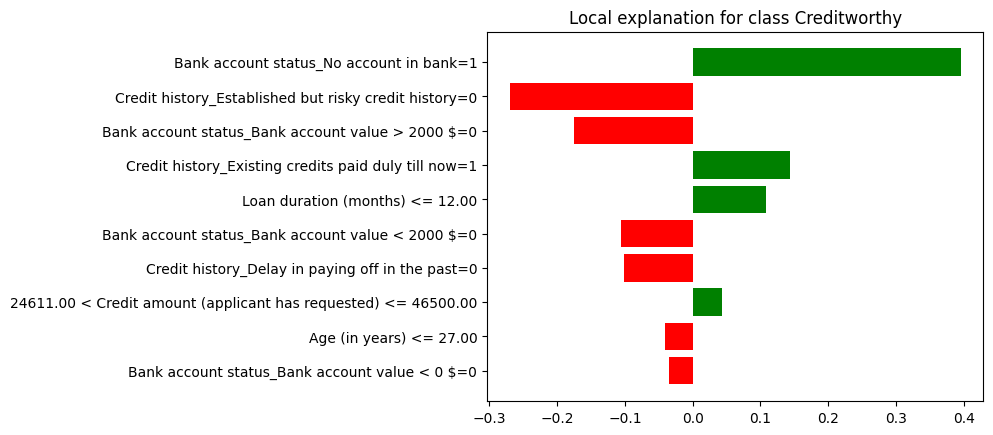

In [18]:
print("Explanation for Instance:", instance_idx)
print(exp.as_list())

# exp.show_in_notebook()
exp.as_pyplot_figure()
plt.show()

### SHAP global+local

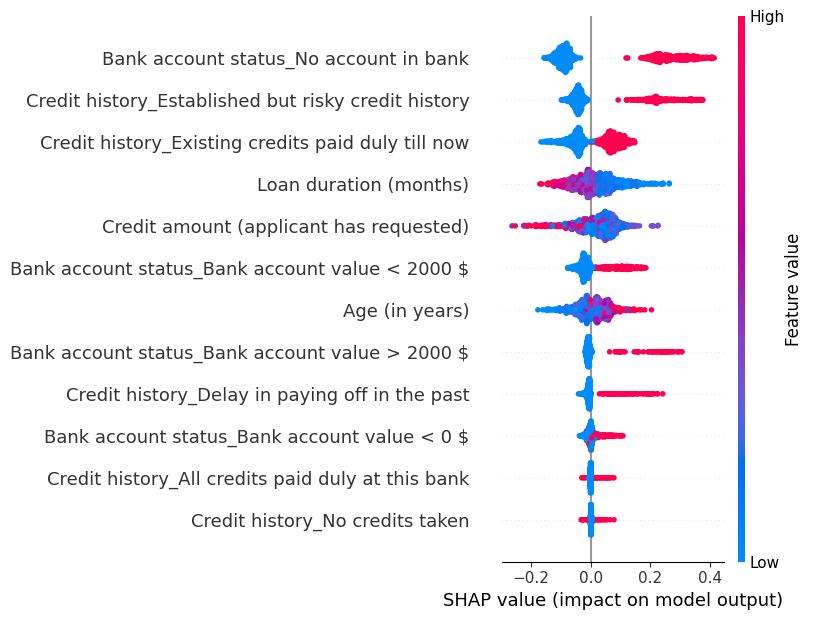

In [19]:
import shap

# Ensure test set matches trained model columns
X_cut = X_cut.reindex(columns=rf_cut.feature_names_in_, fill_value=0)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_cut)

# Compute SHAP values (shape: (num_samples, num_features, num_classes))
shap_values = explainer.shap_values(X_cut)

# Extract SHAP values for the "positive" class (class index 1)
shap_values_class1 = shap_values[:, :, 1]  # Correct slicing

# Generate SHAP plots
shap.summary_plot(shap_values_class1, X_cut)  # Beeswarm plot

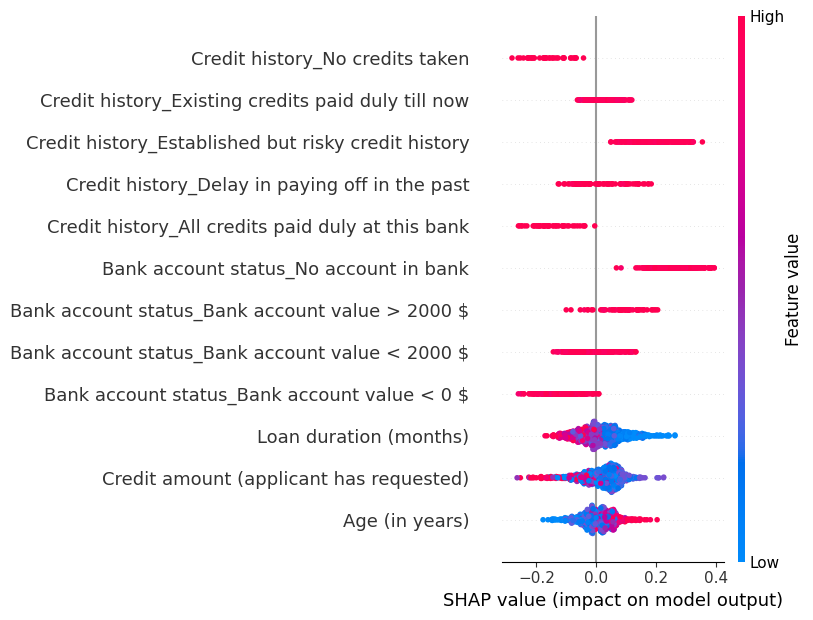

In [ ]:
# BASIC version of global SHAP

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_cut)

# Compute SHAP values (shape: (num_samples, num_features, num_classes))
shap_values = explainer.shap_values(X_cut)

# Extract SHAP values for the "positive" class (class index 1)
shap_values_class1 = shap_values[:, :, 1]  # Correct slicing

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values_class1, columns=X_cut.columns)

# Dictionary to map original categorical feature names (grouped) to their one-hot encoded versions
categorical_feature_groups = {
    "Credit history": [
        "Credit history_All credits paid duly at this bank",
        "Credit history_Delay in paying off in the past",
        "Credit history_Established but risky credit history",
        "Credit history_Existing credits paid duly till now",
        "Credit history_No credits taken"
    ],
    "Bank account status": [
        "Bank account status_Bank account value < 0 $",
        "Bank account status_Bank account value < 2000 $",
        "Bank account status_Bank account value > 2000 $",
        "Bank account status_No account in bank"
    ]
}

# Aggregate SHAP values for categorical features
for feature_name, one_hot_encoded_features in categorical_feature_groups.items():
    for i in range(len(shap_df)):
        sum = shap_df.iloc[i][one_hot_encoded_features].sum()
        for feature in one_hot_encoded_features:
            if X_cut.iloc[i][feature] == 1:
                shap_df.iloc[i][feature] = sum
            else:
                shap_df.iloc[i][feature] = None

# Function to convert boolean column to float and add noise with some probability
def convert_boolean_with_noise(column: pd.Series, noise_prob: float = .5, noise_level: float = 0.1) -> pd.Series:
    """
    Converts a boolean column to float (0.0 or 1.0) and adds a small random noise with a given probability.
    
    Parameters:
    - column (pd.Series): Boolean column to be converted.
    - noise_prob (float): Probability of adding noise (default: 0.2, meaning 20% of values get noise).
    - noise_level (float): Maximum noise magnitude to add (default: 0.05).
    
    Returns:
    - pd.Series: Transformed column with noise applied.
    """
    # Convert boolean to float (0.0 or 1.0)
    column_float = column.astype(float)
    
    # Generate random mask where noise will be added
    noise_mask = np.random.rand(len(column)) < noise_prob
    
    # Generate noise values
    noise = np.random.uniform(-noise_level, noise_level, size=len(column))
    
    # Apply noise only to selected values
    column_float[noise_mask] += noise[noise_mask]
    
    return column_float

X_cut_noise = X_cut.copy()

# Add random noise to tweak categorical a bit for better representation in plot
for feature_name, one_hot_encoded_features in categorical_feature_groups.items():
    for feature in one_hot_encoded_features:
        X_cut_noise[feature] = convert_boolean_with_noise(X_cut_noise[feature])

shap.summary_plot(shap_df.to_numpy(), X_cut_noise, plot_type='dot')


#### Creating plots for samples

In [ ]:
# Creating local figures of SHAP for picked_samples

original_column_names = df_cut.columns
picked_samples = pd.read_csv("data/german/picked_samples.csv")[original_column_names]

# Find indexes of rows that we have in picked_samples to take out SHAP values and data in correct format
continuos_columns = ['Age (in years)', 'Loan duration (months)', 'Credit amount (applicant has requested)']
matching_indices = X_cut[X_cut[continuos_columns].apply(tuple, axis=1).isin(
    picked_samples[continuos_columns].apply(tuple, axis=1)
)].index

# Check that the length is same
matching_indices = matching_indices[:-1]
assert len(picked_samples) == len(matching_indices)

# For each sample create corresponding local XAI
for i, idx in enumerate(matching_indices):
    shap_values_sample = shap_df.to_numpy()[idx]
    X_sample = X_cut.to_numpy()[idx]

    # Create a mask to filter out NaN values
    mask = ~np.isnan(shap_values_sample)  # True where values are NOT NaN

    # Filter SHAP values and feature names based on the mask
    filtered_shap_values = shap_values_sample[mask]
    filtered_feature_names = np.array(X_cut.columns)[mask]

    renaming_dict = {}
    for j in range(len(filtered_feature_names)):
        if "_" in filtered_feature_names[j]:
            filtered_feature_names[j] = filtered_feature_names[j].replace('_', ': ')
        elif filtered_feature_names[j] in continuos_columns:
            filtered_feature_names[j] = filtered_feature_names[j] + ": " + str(X_sample[j])

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, len(filtered_feature_names) * 0.5))  # Adjust height dynamically
    # fig, ax = plt.subplots()

    # Manually plot the SHAP values as a scatter plot
    ax.scatter(
        filtered_shap_values,  # SHAP values on x-axis
        np.arange(len(filtered_feature_names)),  # Feature index on y-axis
        color='red',  # Set all dots to red
        s=100,  # Adjust dot size for visibility
        alpha=0.7
    )

    # Set y-axis labels to filtered feature names
    ax.set_yticks(np.arange(len(filtered_feature_names)))
    ax.set_yticklabels(filtered_feature_names, fontsize=12)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='black', linestyle="-", alpha=0.5)  # Reference line at zero

    # Set labels
    ax.set_xlabel("SHAP value (impact on model output)")
    # Remove unnecessary elements
    plt.box(False)  # Remove box around the plot

    plt.savefig(f"data/german/xai_images/local/picked_samples_{i}.png", bbox_inches='tight', dpi=300)  # Save as PNG
    plt.close(fig)

In [ ]:
# Creating local figures of SHAP for picked_samples_main

original_column_names = df_cut.columns
picked_samples = pd.read_csv("data/german/picked_samples_main.csv")[original_column_names]

# Find indexes of rows that we have in picked_samples to take out SHAP values and data in correct format
continuos_columns = ['Age (in years)', 'Loan duration (months)', 'Credit amount (applicant has requested)']
matching_indices = X_cut[X_cut[continuos_columns].apply(tuple, axis=1).isin(
    picked_samples[continuos_columns].apply(tuple, axis=1)
)].index

# Check that the length is same
matching_indices = matching_indices
assert len(picked_samples) == len(matching_indices)

# For each sample create corresponding local XAI
for i, idx in enumerate(matching_indices):
    shap_values_sample = shap_df.to_numpy()[idx]
    X_sample = X_cut.to_numpy()[idx]

    # Create a mask to filter out NaN values
    mask = ~np.isnan(shap_values_sample)  # True where values are NOT NaN

    # Filter SHAP values and feature names based on the mask
    filtered_shap_values = shap_values_sample[mask]
    filtered_feature_names = np.array(X_cut.columns)[mask]

    renaming_dict = {}
    for j in range(len(filtered_feature_names)):
        if "_" in filtered_feature_names[j]:
            filtered_feature_names[j] = filtered_feature_names[j].replace('_', ': ')
        elif filtered_feature_names[j] in continuos_columns:
            filtered_feature_names[j] = filtered_feature_names[j] + ": " + str(X_sample[j])

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, len(filtered_feature_names) * 0.5))  # Adjust height dynamically
    # fig, ax = plt.subplots()

    # Manually plot the SHAP values as a scatter plot
    ax.scatter(
        filtered_shap_values,  # SHAP values on x-axis
        np.arange(len(filtered_feature_names)),  # Feature index on y-axis
        color='red',  # Set all dots to red
        s=100,  # Adjust dot size for visibility
        alpha=0.7
    )

    # Set y-axis labels to filtered feature names
    ax.set_yticks(np.arange(len(filtered_feature_names)))
    ax.set_yticklabels(filtered_feature_names, fontsize=12)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='black', linestyle="-", alpha=0.5)  # Reference line at zero

    # Set labels
    ax.set_xlabel("SHAP value (impact on model output)")
    # Remove unnecessary elements
    plt.box(False)  # Remove box around the plot

    plt.savefig(f"data/german/xai_images/local/picked_samples_main_{i}.png", bbox_inches='tight', dpi=300)  # Save as PNG
    plt.close(fig)

In [ ]:
# Creating global figures of SHAP for picked_samples
original_column_names = df_cut.columns
picked_samples = pd.read_csv("data/german/picked_samples.csv")[original_column_names]

for i, row in picked_samples.iterrows():
    columns_to_take_from_shap = ['Age (in years)', 'Loan duration (months)', 'Credit amount (applicant has requested)']
    for key in categorical_feature_groups.keys():
        value = row[key]
        needed_dummy_column = key+"_"+value
        columns_to_take_from_shap.append(needed_dummy_column)
    # Print the plot with only needed lines
    shap_df_for_sample = shap_df[columns_to_take_from_shap]
    X_cut_noise_for_sample = X_cut_noise[columns_to_take_from_shap]

    renaming_dict = {}
    for c in shap_df_for_sample.columns:
        if "_" in c:
            renaming_dict[c] = c.replace('_', ': ')

    shap_df_for_sample = shap_df_for_sample.rename(columns=renaming_dict)
    X_cut_noise_for_sample = X_cut_noise_for_sample.rename(columns=renaming_dict)
    fig, ax = plt.subplots()
    shap.summary_plot(shap_df_for_sample.to_numpy(), X_cut_noise_for_sample, plot_type='dot', show=False)
    plt.savefig(f"data/german/xai_images/global/picked_samples_{i}.png", bbox_inches='tight', dpi=300)  # Save as PNG
    plt.close(fig)

In [ ]:
# Creating global figures of SHAP for picked_samples_main
original_column_names = df_cut.columns
picked_samples = pd.read_csv("data/german/picked_samples_main.csv")[original_column_names]

for i, row in picked_samples.iterrows():
    columns_to_take_from_shap = ['Age (in years)', 'Loan duration (months)', 'Credit amount (applicant has requested)']
    for key in categorical_feature_groups.keys():
        value = row[key]
        needed_dummy_column = key+"_"+value
        columns_to_take_from_shap.append(needed_dummy_column)
    # Print the plot with only needed lines
    shap_df_for_sample = shap_df[columns_to_take_from_shap]
    X_cut_noise_for_sample = X_cut_noise[columns_to_take_from_shap]

    renaming_dict = {}
    for c in shap_df_for_sample.columns:
        if "_" in c:
            renaming_dict[c] = c.replace('_', ': ')

    shap_df_for_sample = shap_df_for_sample.rename(columns=renaming_dict)
    X_cut_noise_for_sample = X_cut_noise_for_sample.rename(columns=renaming_dict)
    fig, ax = plt.subplots()
    shap.summary_plot(shap_df_for_sample.to_numpy(), X_cut_noise_for_sample, plot_type='dot', show=False)
    plt.savefig(f"data/german/xai_images/global/picked_samples_main_{i}.png", bbox_inches='tight', dpi=300)  # Save as PNG
    plt.close(fig)

#### Checking density

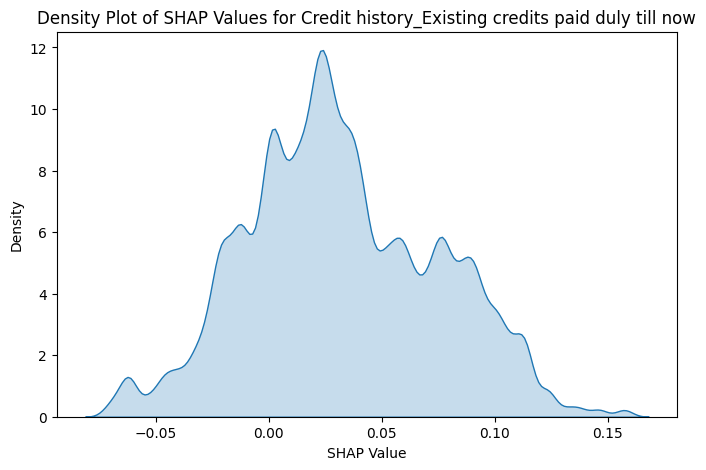

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot density of SHAP values for a given categorical feature
def plot_shap_density(shap_df, feature_name):
    # Extract non-null SHAP values for the selected categorical feature
    shap_values = shap_df[feature_name].dropna()

    # Plot density distribution
    plt.figure(figsize=(8, 5))
    sns.kdeplot(shap_values, fill=True, bw_adjust=0.3)
    plt.xlabel("SHAP Value")
    plt.ylabel("Density")
    plt.title(f"Density Plot of SHAP Values for {feature_name}")
    plt.show()

# Example usage
plot_shap_density(shap_df, "Credit history_Existing credits paid duly till now")


### Analysing feature importance

In [12]:
df_cut.columns

Index(['Bank account status', 'Loan duration (months)', 'Credit history',
       'Age (in years)', 'Credit amount (applicant has requested)', 'class'],
      dtype='object')

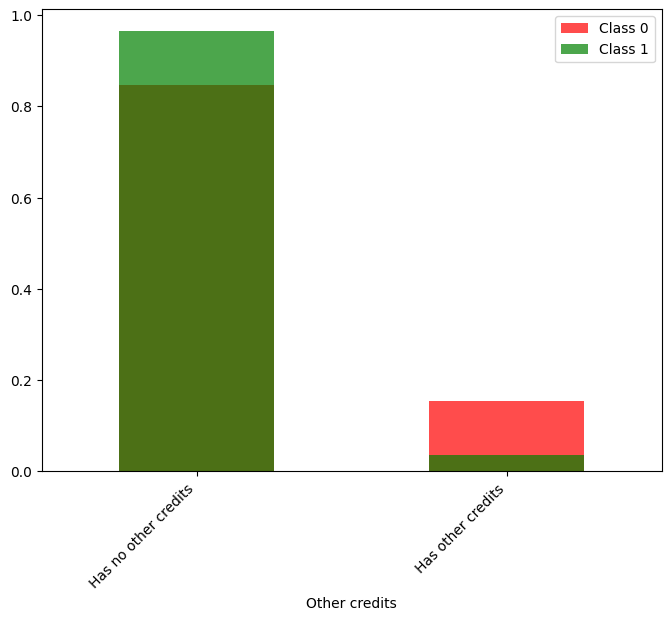

In [135]:
feature = 'Other credits'

# Set figure size and font size
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})

# INDICATIVE SAMPLES
values_class_0 = df_cut.iloc[best_samples[0]][feature].value_counts(normalize=True).sort_index()
values_class_1 = df_cut.iloc[best_samples[1]][feature].value_counts(normalize=True).sort_index()

# ALL SAMPLES
# values_class_0 = df_cut[df_cut['class']==0][feature].value_counts(normalize=True).sort_index()
# values_class_1 = df_cut[df_cut['class']==1][feature].value_counts(normalize=True).sort_index()

# Plot normalized histograms for each class
values_class_0.plot(
    kind='bar', alpha=0.7, label='Class 0', color='red'
)
values_class_1.plot(
    kind='bar', alpha=0.7, label='Class 1', color='green'
)

plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right

plt.show()

## GlocalX

In [83]:
import numpy as np
import logzero
import pickle
from pprint import pprint
from lore_explainer.datamanager import prepare_adult_dataset, prepare_dataset, prepare_german_dataset

from glocalx import GLocalX, shut_up_tensorflow
from rule_loaders.lore_to_glocalx import lore_to_glocalx


# Set log profile: INFO for normal logging, DEBUG for verbosity
logzero.loglevel(logzero.logging.DEBUG)
np.set_printoptions(precision=4, suppress=True)
shut_up_tensorflow()

#### Read data

In [ ]:
DATA_FILENAME = 'german'
# Prepare data
if DATA_FILENAME == "adult":
    df_original, class_name = prepare_adult_dataset(f'data/{DATA_FILENAME}.csv')
elif DATA_FILENAME == "german":
    df_original, class_name = df_cut.copy(), 'class'
else:
    raise NotImplementedError
df, feature_names, class_values, numeric_columns, original_df, real_feature_names, features_map = prepare_dataset(
    df_original, class_name)

print("Data size is: ", df.shape)

Data size is:  (1000, 13)


#### Get Lore rules

In [ ]:
# Retrain RF with different names of the columns (glocalx convention)
target_column_name = 'class'
X_cut = df.drop(columns=[target_column_name])
y_cut = df[target_column_name]

X_cut_train, X_cut_test, y_cut_train, y_cut_test = train_test_split(X_cut, y_cut, test_size=0.2, random_state=42)

# Oversample class 0 (bad)
smote = SMOTE(random_state=42)
X_cut_train, y_cut_train = smote.fit_resample(X_cut_train, y_cut_train)

params_cut = params
rf_cut = RandomForestClassifier(**params_cut, class_weight='balanced', random_state=42)
rf_cut.fit(X_cut_train, y_cut_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [ ]:
# Define predicting functions
def bb_predict(X):
    return rf_cut.predict(X)

def bb_predict_proba(X):
    return rf_cut.predict_proba(X)

Y_pred = bb_predict(X_cut_test)

print('Accuracy %.3f' % accuracy_score(y_cut_test, Y_pred))
print('F1-measure %.3f' % f1_score(y_cut_test, Y_pred))

#### Generate LORE rules

In [188]:
from lore_explainer.lorem import LOREM
from lore_explainer.util import neuclidean
import json
import random

DATA_FILENAME = "german"    # CSV name in ./data for which to generate LORE rules
NUM_SAMPLES = 200            # Select num of records to explain

##################################LORE####################################

indices = random.sample(range(len(original_df)), NUM_SAMPLES)
# data = df.drop(columns='class').to_numpy(dtype=np.float32)
data = original_df[real_feature_names].values # For training LORE we need original data without class column

x_to_exp = df[feature_names].values[indices] # For samples to create XAI we need dummy columns

# LORE initialize
lore_explainer = LOREM(data, bb_predict,
                        feature_names, class_name, class_values, numeric_columns, features_map,
                        neigh_type='geneticp',
                        categorical_use_prob=True,
                        continuous_fun_estimation=False,
                        size=1000, ocr=0.1, random_state=42,
                        ngen=10, bb_predict_proba=bb_predict_proba,
                        verbose=False)

rules = []

# warning suppression
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=RuntimeWarning)

    for i in tqdm(range(NUM_SAMPLES)):
        exp = lore_explainer.explain_instance(x_to_exp[i], samples=50, use_weights=True, metric=neuclidean)
        rules.append(exp.rule)

# Create rules file
with open(f"data/lore_rules/lore_rules_{DATA_FILENAME}_{NUM_SAMPLES}.pkl", "wb") as file:
    pickle.dump(rules, file)

# Create info file (for conversion to glocalx rules later)
info_dict = {'feature_names': feature_names, "class_values": class_values}
info_dict['class_values'] = [int(x) for x in info_dict['class_values']] # convert numpy type int to python int for json to dump

with open(f"data/info_files/{DATA_FILENAME}_info.json", "w") as file:
    json.dump(info_dict, file, indent=4)

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


In [ ]:
# Adult data load rules
# Load local explanations
lore_rules_file = "lore_rules_german_{NUM_SAMPLES}"
info_file = "german_info"
glocal_rules = lore_to_glocalx(f"data/lore_rules/{lore_rules_file}.pkl", f"data/info_files/{info_file}.json")
pprint(glocal_rules)

In [190]:
original_df

,Loan duration (months),Credit amount (applicant has requested),Age (in years),Bank account status,Credit history,class
0,6,11700,67,Bank account value < 0 $,Established but risky credit history,1
1,48,59500,22,Bank account value < 2000 $,Existing credits paid duly till now,0
2,12,21000,49,No account in bank,Established but risky credit history,1
3,42,78800,45,Bank account value < 0 $,Existing credits paid duly till now,1
4,24,48700,53,Bank account value < 0 $,Delay in paying off in the past,0
...,...,...,...,...,...,...
995,12,17400,31,No account in bank,Existing credits paid duly till now,1
996,30,38600,40,Bank account value < 0 $,Existing credits paid duly till now,1
997,12,8000,38,No account in bank,Existing credits paid duly till now,1
998,45,18400,23,Bank account value < 0 $,Existing credits paid duly till now,0


In [ ]:
# Create a GLocalX instance for `black_box`
glocalx = GLocalX(model_ai=rf_cut, name="adult_glocal")
# Fit the model, use batch_size=128 for larger datasets
glocalx.fit(rules=glocal_rules, train_set=df.values, batch_size=128)

In [175]:
glocalx.boundary

[{{1: (-inf, 18100.0)}-> 1, {1: (-inf, 69412.5)}-> 1, {0: (-inf, 19.0)}-> 1},
 {{6: (-inf, 0.5), 9: (-inf, 0.5), 10: (-inf, 0.5)}-> 0,
  {6: (-inf, 0.5), 1: (-inf, 18934.119140625), 4: (-inf, 0.5)}-> 0,
  {9: (0.5, inf), 1: (-inf, inf)}-> 1,
  {1: (90482.40625, inf), 5: (-inf, 0.5)}-> 0,
  {10: (-inf, 0.5)}-> 1,
  {0: (34.0, 42.0)}-> 0},
 {{4: (0.5, inf)}-> 1,
  {9: (-inf, 0.5), 1: (31468.0, 39172.486328125), 6: (-inf, 0.5)}-> 1,
  {1: (84200.0, inf), 6: (-inf, 0.5)}-> 0,
  {8: (0.5, inf), 10: (-inf, 0.5)}-> 1},
 {{6: (-inf, 0.5), 3: (-inf, 0.5), 1: (22550.0, inf)}-> 1,
  {6: (-inf, 0.5), 0: (-inf, 13.524701118469238), 10: (-inf, 0.5)}-> 0,
  {1: (-inf, 11100.0), 6: (-inf, 0.5), 0: (-inf, 15.0), 2: (-inf, 39.5)}-> 0,
  {6: (-inf, 0.5), 1: (16650.0, 60897.0), 4: (0.5, inf), 9: (-inf, 0.5), 3: (-inf, 0.5), 2: (-inf, 42.5), 0: (-inf, 25.5)}-> 0,
  {1: (71673.0, inf), 6: (-inf, 0.5), 0: (23.5, inf)}-> 0,
  {5: (0.5, inf), 0: (3.0, 28.5)}-> 1},
 {{6: (-inf, 0.5), 2: (-inf, 51.5), 0: (4.5, i

In [176]:
glocalx.fine_boundary

{{4: (0.5, inf)}-> 1,
 {6: (-inf, 0.5), 9: (-inf, 0.5), 10: (-inf, 0.5)}-> 0,
 {1: (-inf, 18100.0)}-> 1,
 {6: (-inf, 0.5), 1: (-inf, 18934.119140625), 4: (-inf, 0.5)}-> 0,
 {1: (-inf, 69412.5)}-> 1,
 {9: (0.5, inf), 1: (-inf, inf)}-> 1,
 {6: (-inf, 0.5), 3: (-inf, 0.5), 1: (22550.0, inf)}-> 1,
 {9: (-inf, 0.5), 1: (31468.0, 39172.486328125), 6: (-inf, 0.5)}-> 1,
 {1: (84200.0, inf), 6: (-inf, 0.5)}-> 0,
 {1: (90482.40625, inf), 5: (-inf, 0.5)}-> 0,
 {8: (0.5, inf), 10: (-inf, 0.5)}-> 1,
 {10: (-inf, 0.5)}-> 1,
 {6: (-inf, 0.5), 0: (-inf, 13.524701118469238), 10: (-inf, 0.5)}-> 0,
 {1: (-inf, 11100.0), 6: (-inf, 0.5), 0: (-inf, 15.0), 2: (-inf, 39.5)}-> 0,
 {0: (-inf, 19.0)}-> 1,
 {6: (-inf, 0.5), 1: (16650.0, 60897.0), 4: (0.5, inf), 9: (-inf, 0.5), 3: (-inf, 0.5), 2: (-inf, 42.5), 0: (-inf, 25.5)}-> 0,
 {1: (71673.0, inf), 6: (-inf, 0.5), 0: (23.5, inf)}-> 0,
 {5: (0.5, inf), 0: (3.0, 28.5)}-> 1,
 {0: (34.0, 42.0)}-> 0,
 {6: (-inf, 0.5), 2: (-inf, 51.5), 0: (4.5, inf)}-> 0}

In [185]:
# Retrieve global explanations by fidelity percentile
alpha = 0.9
global_explanations = glocalx.get_fine_boundary_alpha(alpha)
global_explanations

[{1: (-inf, 11100.0), 6: (-inf, 0.5), 0: (-inf, 15.0), 2: (-inf, 39.5)}-> 0,
 {6: (-inf, 0.5), 0: (-inf, 13.524701118469238), 10: (-inf, 0.5)}-> 0,
 {6: (-inf, 0.5), 1: (16650.0, 60897.0), 4: (0.5, inf), 9: (-inf, 0.5), 3: (-inf, 0.5), 2: (-inf, 42.5), 0: (-inf, 25.5)}-> 0,
 {6: (-inf, 0.5), 1: (-inf, 18934.119140625), 4: (-inf, 0.5)}-> 0,
 {6: (-inf, 0.5), 9: (-inf, 0.5), 10: (-inf, 0.5)}-> 0,
 {1: (90482.40625, inf), 5: (-inf, 0.5)}-> 0,
 {1: (71673.0, inf), 6: (-inf, 0.5), 0: (23.5, inf)}-> 0,
 {0: (34.0, 42.0)}-> 0,
 {1: (84200.0, inf), 6: (-inf, 0.5)}-> 0,
 {6: (-inf, 0.5), 2: (-inf, 51.5), 0: (4.5, inf)}-> 0,
 {6: (-inf, 0.5), 3: (-inf, 0.5), 1: (22550.0, inf)}-> 1,
 {8: (0.5, inf), 10: (-inf, 0.5)}-> 1,
 {10: (-inf, 0.5)}-> 1,
 {1: (-inf, 18100.0)}-> 1,
 {9: (-inf, 0.5), 1: (31468.0, 39172.486328125), 6: (-inf, 0.5)}-> 1,
 {5: (0.5, inf), 0: (3.0, 28.5)}-> 1]

In [202]:
# Retrieve exactly `alpha` global explanations
alpha = 4
global_explanations = glocalx.get_fine_boundary_alpha(alpha)
global_explanations

[{1: (71673.0, inf), 6: (-inf, 0.5), 0: (23.5, inf)}-> 0,
 {0: (34.0, 42.0)}-> 0,
 {1: (84200.0, inf), 6: (-inf, 0.5)}-> 0,
 {6: (-inf, 0.5), 2: (-inf, 51.5), 0: (4.5, inf)}-> 0,
 {10: (-inf, 0.5)}-> 1,
 {1: (-inf, 18100.0)}-> 1,
 {9: (-inf, 0.5), 1: (31468.0, 39172.486328125), 6: (-inf, 0.5)}-> 1,
 {5: (0.5, inf), 0: (3.0, 28.5)}-> 1]

In [203]:
glocalx.evaluator.bic(global_explanations)

13:39:33 | 	| Log-like: 0.9690 Complexity: 0.1667


-0.9688333333333333

In [204]:
glocalx.evaluator.binary_fidelity_model(global_explanations)

0.969

#### Reformat GlocalX rules for representability

In [200]:
glocal_rules[0].consequence

1

In [ ]:
# Redefining the function since the execution state was reset

def format_rule_conditions(rules):
    formatted_rules = []
    
    for rule in rules:
        premises = rule.premises
        outcome = rule.consequence
        formatted_rule = {}
        
        for key, (low, high) in premises.items():
            if key == 1:  # Money Amount
                if low == float('-inf'):
                    formatted_rule[key] = f"<{round(high / 1000)}k"
                elif high == float('inf'):
                    formatted_rule[key] = f">{round(low / 1000)}k"
                else:
                    formatted_rule[key] = f"{round(low / 1000)}k-{round(high / 1000)}k"

            elif key == 0 or key == 2:  # Loan Duration or Age
                if low == float('-inf'):
                    formatted_rule[key] = f"<{int(high)}"
                elif high == float('inf'):
                    formatted_rule[key] = f">{int(low) + 1}"
                else:
                    formatted_rule[key] = f"{int(low) + 1}-{int(high) - 1}"

            else:  # Binary Features
                if high == 0.5:
                    formatted_rule[key] = "False"
                elif low == 0.5:
                    formatted_rule[key] = "True"

        formatted_rules.append((formatted_rule, outcome))
    
    return formatted_rules

# Apply transformation
formatted_rules = format_rule_conditions(global_explanations)

formatted_rules

[({1: '>72k', 6: 'False', 0: '>24'}, 0),
 ({0: '35-41'}, 0),
 ({1: '>84k', 6: 'False'}, 0),
 ({6: 'False', 2: '<51', 0: '>5'}, 0),
 ({10: 'False'}, 1),
 ({1: '<18k'}, 1),
 ({9: 'False', 1: '31k-39k', 6: 'False'}, 1),
 ({5: 'True', 0: '4-27'}, 1)]